In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
import scipy
from wraparound import wraparound
%output size=150
pi_ticks = [(-np.pi, r'$-\pi$'), (0, '0'), (np.pi, r'$\pi$')]


def haldane(w=20, boundary='zigzag'):
    def ribbon_shape_zigzag(pos):
        return (-0.5 / np.sqrt(3) - 0.1 <= pos[1] < np.sqrt(3) * w / 2 + 0.01)

    def ribbon_shape_armchair(pos):
        return (-1 <= pos[0] < w)

    def onsite(site, p):
        if site.family == a:
            return p.m
        else:
            return -p.m

    def nn_hopping(site1, site2, p):
        return p.t

    def nnn_hopping(site1, site2, p):
        return 1j * p.t_2

    lat = kwant.lattice.honeycomb()
    a, b = lat.sublattices
    nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
    nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))

    if boundary == 'zigzag':
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
        sys[lat.shape(ribbon_shape_zigzag, (0, 0))] = onsite
    elif boundary == 'armchair':
        sys = kwant.Builder(kwant.TranslationalSymmetry((0, np.sqrt(3))))
        sys[lat.shape(ribbon_shape_armchair, (0, 0))] = onsite
    else:
        sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs)) 
        sys[lat.shape(lambda pos: True, (0, 0))] = onsite
    
    sys[lat.neighbors()] = nn_hopping
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings_a]] = nnn_hopping
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings_b]] = nnn_hopping

    return sys


def Qi_Wu_Zhang():
    def onsite(site, p):
        return - p.mu * pauli.sz
    
    def hopx(site1, site2, p):
        return - 0.5j * p.delta * pauli.sy - p.t * pauli.sz
    
    def hopy(site1, site2, p):
        return - 1j * p.gamma * pauli.sx  - p.gamma * pauli.sz  
    
    lat = kwant.lattice.square()

    sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
    sys[lat.shape(lambda pos: True, (0, 0))] = onsite
    sys[kwant.HoppingKind((1,0), lat)] = hopx
    sys[kwant.HoppingKind((0,1), lat)] = hopy
    return sys


def berry_curvature(sys, p, ks, num_filled_bands=1):
    """Berry curvature of a system.
    
    Parameters:
    -----------
    sys : kwant.Builder
        A 2D infinite system.
    p : SimpleNamespace
        The arguments expected by the system.
    ks : 1D array-like
        Values of momentum grid to be used for Berry curvature calculation.
    num_filled_bands : int
        The number of filled bands.

    Returns:
    --------
    bc : 2D array
        Berry curvature on each square in a `ks x ks` grid.
    """
    # Calculate an array of eigenvectors.
    B = np.array(sys.symmetry.periods).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))

    sys = wraparound(sys).finalized()

    def energy(kx, ky):
        k = np.array([kx, ky])
        kx, ky = np.linalg.solve(A, k)
        H = sys.hamiltonian_submatrix([p, kx, ky], sparse=False)
        return scipy.linalg.eigh(H)[1]
    
    vectors = np.array([[energy(kx, ky)[:, :num_filled_bands] for kx in ks] for ky in ks])
    
    # The actual Berry curvature calculation
    vectors_x = np.roll(vectors, 1, 0)
    vectors_xy = np.roll(vectors_x, 1, 1)
    vectors_y = np.roll(vectors, 1, 1)

    shifted_vecs = [vectors, vectors_x, vectors_xy, vectors_y]

    v_shape = vectors.shape

    shifted_vecs = [i.reshape(-1, v_shape[-2], v_shape[-1]) for i in shifted_vecs]

    dets = np.ones(len(shifted_vecs[0]), dtype=complex)
    for vec, shifted in zip(shifted_vecs, np.roll(shifted_vecs, 1, 0)):
        dets *= [np.linalg.det(a.T.conj().dot(b)) for a, b in zip(vec, shifted)]
    bc = np.angle(dets).reshape(int(np.sqrt(len(dets))), -1)    
    
    bc = (bc + np.pi / 2) % (np.pi) - np.pi / 2
    
    return bc


def plot_berry_curvature(sys, p, ks=None, title=None):    
    if ks is None:
        ks = np.linspace(-np.pi, np.pi, 150, endpoint=False)
    bc = berry_curvature(sys, p, ks)[1:-1,1:-1]
    vmax = max(np.abs(bc).min(), np.abs(bc).max())
    kwargs = {'bounds': (ks.min(), ks.min(), ks.max(), ks.max()),
              'kdims': [r'$k_x$', r'$k_y$']}

    if callable(title):
        kwargs['label'] = title(p)

    plot = {'xticks': pi_ticks, 'yticks': pi_ticks}
    style = {'clims': [-vmax, vmax]}
    return holoviews.Image(bc, **kwargs)(plot=plot, style=style)


def title(p):
    title = r'$t={:.2}$, $t_2={:.2}$, $M={:.2}$'
    return title.format(p.t, p.t_2, p.m)

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

# Intro

Duncan Haldane from Princeton University will teach us about an interesting two dimensional toy-model which he [introduced](http://faculty.washington.edu/cobden/papers/haldane88.pdf) in 1988, and which has become a prototype for the anomalous quantum Hall effect.

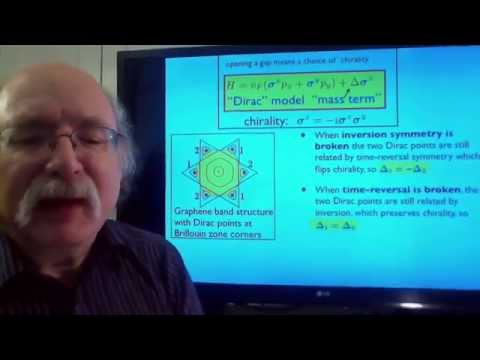

In [2]:
MoocVideo("7nVO4uMm-do", src_location='4.2-intro')

We will now study the model in detail, starting from the beginning.  Along the way, we will also learn about the Chern number, the bulk topological invariant of a quantum Hall state.

# Dirac cones in graphene

In the last chapter we saw how it is possible to obtain a quantum Hall state by coupling one-dimensional systems. At the end, our recipe was to first obtain a Dirac cone, add a mass term to it and finally to make this mass change sign. Following this recipe we were able to obtain chiral edge states without applying an external magnetic field.

There is a real (and a very important) two-dimensional system which has Dirac cones: [graphene](http://en.wikipedia.org/wiki/Graphene). So in this chapter we will take graphene and make it into a topological system with chiral edge states.

Graphene is a single layer of carbon atoms arranged in a honeycomb lattice. It is a triangular lattice with two atoms per unit cell, type $A$ and type $B$, represented by red and blue sites in the figure:

![](figures/graphene.svg)

Hence, the wave function in a unit cell can be written as a vector $(\Psi_A, \Psi_B)^T$ of amplitudes on the two sites $A$ and $B$. Taking a simple tight-binding model where electrons can hop between neighboring sites with hopping strength $t$, one obtains the Bloch Hamiltonian:

$$
H_0(\mathbf{k})= \begin{pmatrix} 0 & h(\mathbf{k}) \\ h^\dagger(\mathbf{k}) & 0 \end{pmatrix}\,,
$$

with $\mathbf{k}=(k_x, k_y)$ and

$$h(\mathbf{k}) = t_1\,\sum_i\,\exp\,\left(i\,\mathbf{k}\cdot\mathbf{a}_i\right)\,.$$

Here $\mathbf{a}_i$ are the three vectors in the figure, connecting nearest neighbors of the lattice [we set the lattice spacing to one, so that for instance $\mathbf{a}_1=(1,0)$].  Introducing a set of Pauli matrices $\sigma$ which act on the sublattice degree of freedom, we can write the Hamiltonian in a compact form as

$$H_0(\mathbf{k}) = t_1\,\sum_i\,\left[\sigma_x\,\cos(\mathbf{k}\cdot\mathbf{a}_i)-\sigma_y \,\sin(\mathbf{k}\cdot\mathbf{a}_i)\right]\,.$$

The energy spectrum $E(\mathbf{k}) = \pm \,\left|h(\mathbf{k})\right|$ gives rise to the famous band structure of graphene, with the two bands touching at the six corners of the Brillouin zone:

:Overlay
   .Surface.I  :Surface   [$k_x$,$k_y$]   ($E$)
   .Surface.II :Surface   [$k_x$,$k_y$]   ($E$)
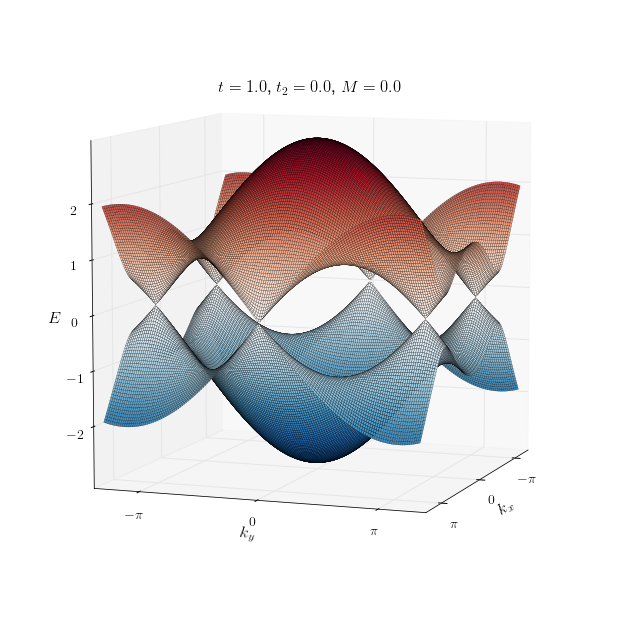

In [3]:
p = SimpleNamespace(t=1.0, t_2=0.0, m=0.0, phi=np.pi/2)
sys = haldane(boundary='infinite')
k = (4 / 3) * np.linspace(-np.pi, np.pi, 150)
spectrum(sys, p, k_x=k, k_y=k, title=title)

Only two of these six Dirac cones are really distinct, the ones at $\mathbf{K}=(2\pi/3, 2\pi/3\sqrt{3})$ and $\mathbf{K}'=(2\pi/3, -2\pi/3\sqrt{3})$. All the others can be obtained by adding some reciprocal lattice vector to $\mathbf{K}$ and $\mathbf{K}'$.

# Discrete symmetries of graphene

The symmetries of graphene were discussed intensively in the video, so let's review them.

As we already said in our first week, graphene is the prototype of a system with sublattice symmetry, which makes the Hamiltonian block off-diagonal with respect to the two sublattices. The sublattice symmetry reads

$$\sigma_z\,H_0(\mathbf{k})\,\sigma_z = -H_0(\mathbf{k})\,.$$

Sublattice symmetry is only approximate, and it is consequence of the nearest neighbor tight-binding model. Just like the inversion symmetry mentioned in the video, it protects the Dirac points and needs to be broken in order to open a gap.

In addition to sublattice and inversion symmetry, the honeycomb lattice also has a three-fold rotation symmetry around the center of the unit cell. This symmetry is important to make the Dirac cones appear in the first place, but it will not play a role in all that follows.

Finally, there is time-reversal symmetry, which at the moment is perfectly preserved in our tight-binding model. Since we are not considering the spin degree of freedom of the electrons, the time-reversal symmetry operator in real space is just complex conjugation. In momentum space representation, time-reversal symmetry reads

$$ H_0(\mathbf{k}) = H_0^*(-\mathbf{k})\,.$$

It's important to note that time-reversal symmetry sends $\mathbf{K}$ into $\mathbf{K}'$ and therefore it exchanges the two Dirac cones.

The product of (approximate) sublattice and time-reversal symmetries yields a further discrete symmetry, a particle-hole symmetry $\sigma_z H^*(-\mathbf{k})\,\sigma_z = -H_0(\mathbf{k})$.

# Making graphene topological

Let's recall that our goal is to make our graphene sheet enter a quantum Hall state, with chiral edge states. The first necessary step is to make the bulk of the system gapped. 

How can we open a gap in graphene? The Dirac points are protected by both sublattice (inversion) and time-reversal symmetry. So there are many ways we can think of to open an energy gap at $\mathbf{K}$ and $\mathbf{K}'$.

## First try

The easiest way to break sublattice symmetry is to assign an opposite onsite energy $M$ or $-M$ to the $A$ or $B$ sites respectively. The Hamiltonian is then given by

$$ H_0(\mathbf{k}) + M\,\sigma_z\,.$$

This leads to a gapped spectrum,

$$E(\mathbf{k})=\pm \sqrt{\left|h(\mathbf{k})\right|^2 + M^2}\,.$$

However, we quickly realize that by doing this we end up in a rather boring situation. Taking the limit $\left|M\right| \gg t_1$, we obtain electronic states which are localized in one of the two sublattices $A$ or $B$, independent of the sign of $M$. Most importantly, there is no trace of edge states.

It's easy to see why this mass term is hopeless: it preserves time-reversal symmetry. And with the time-reversal symmetry present, it is definitely impossible to obtain chiral edge states.

## Second try

There is another, more ingenious way to gap out the Dirac cones in graphene, which is the essence of today's model. It involves adding imaginary second-nearest neighbor hoppings, with the following distinctive pattern:

![](figures/haldane_hoppings.svg)

With the direction of the arrow, we denote the direction in which the hopping is $+it_2$ (it is $-it_2$ in the opposite direction).

Note the following things about these hoppings:

* they are purely imaginary and, furthermore, they all have the same chirality, in the sense that they all follow the orientation of your right hand, if the thumb points out from the screen.
* they couple sites of same type: $A$ with $A$ and $B$ with $B$.

These characteristics tell us that the new hoppings break both time-reversal symmetry and sublattice symmetry. Now the full Hamiltonian becomes

$$
H(\mathbf{k}) = H_0(\mathbf{k})+ M\sigma_z + 2t_2\sum_i\,\sigma_z\,\sin(\mathbf{k}\cdot\mathbf{b}_i)\,.
$$

The last term changes sign under time-reversal symmetry, breaking it. This is the Hamiltonian of the Haldane model.

Let's see what happens to the system when these special second neighbor hoppings are turned on:

b':HoloMap   [$t_2$]\n   :Overlay\n      .Surface.I  :Surface   [$k_x$,$k_y$]   ($E$)\n      .Surface.II :Surface   [$k_x$,$k_y$]   ($E$)'
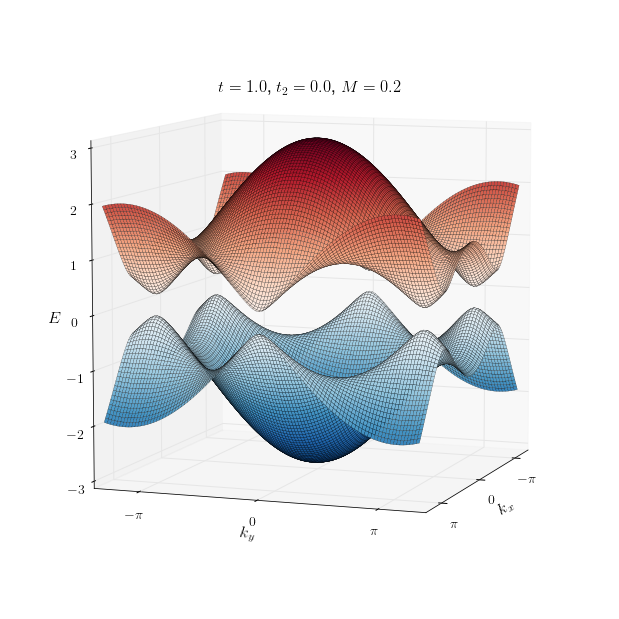
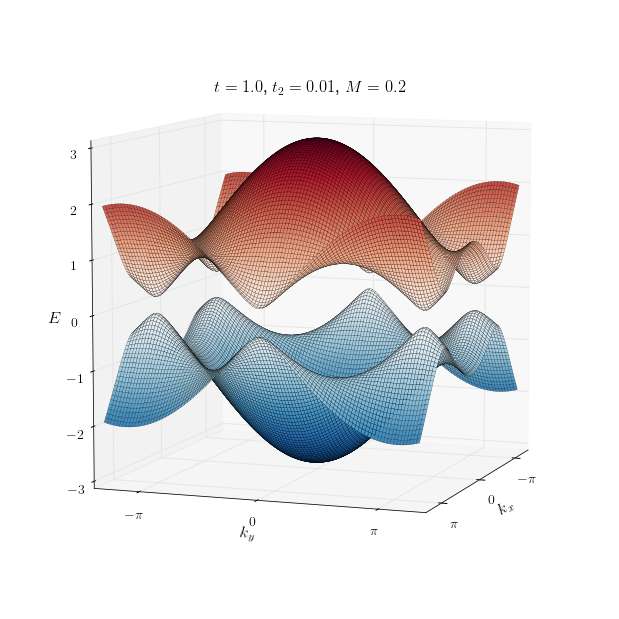
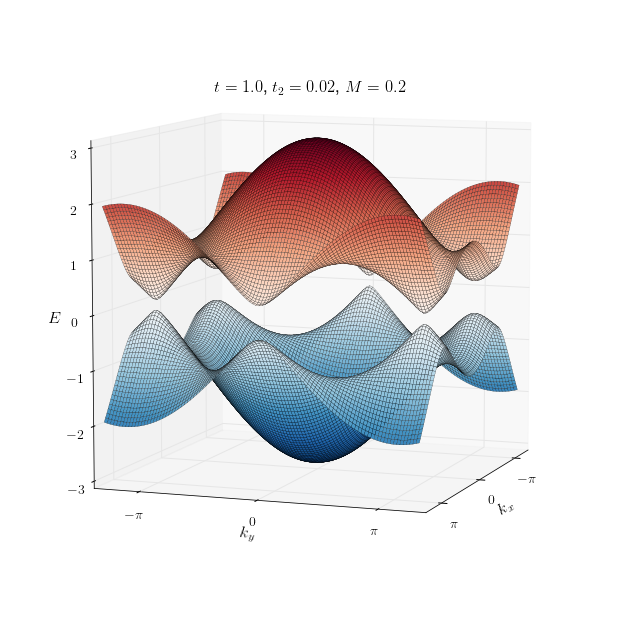
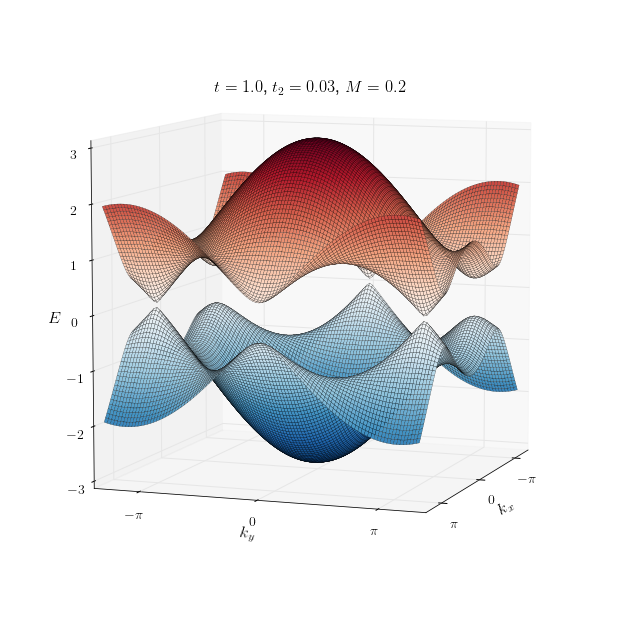
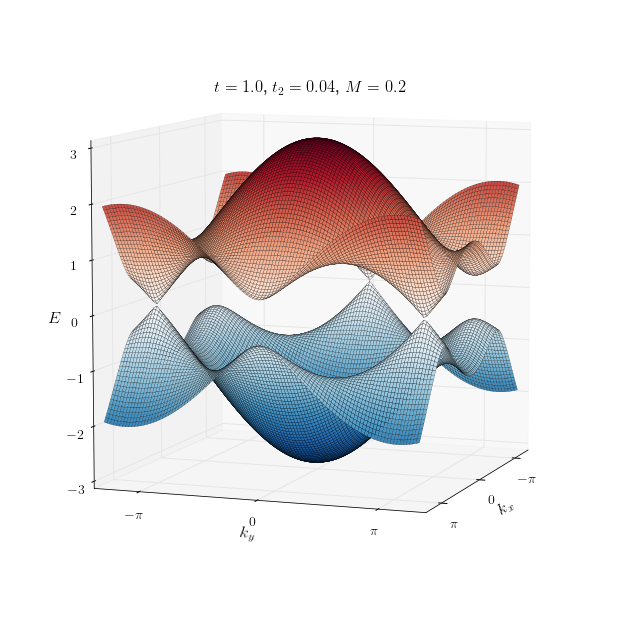
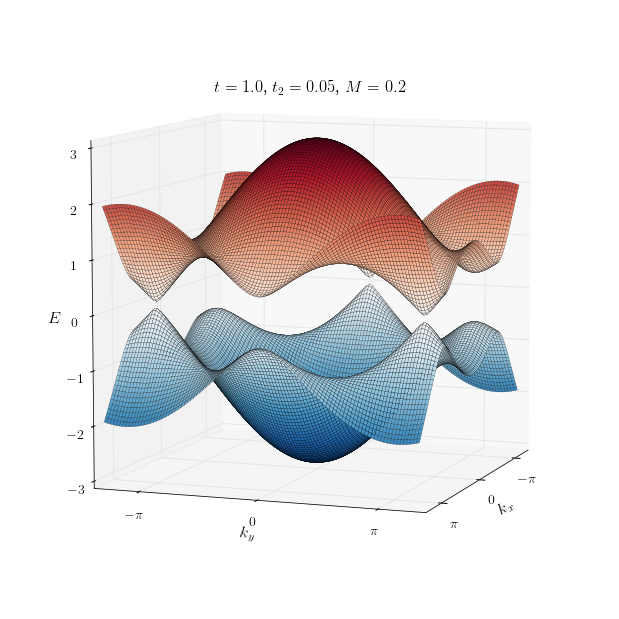
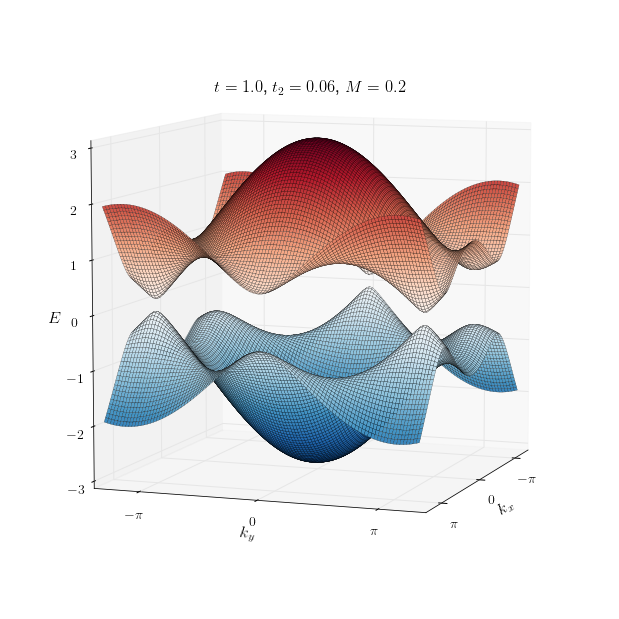
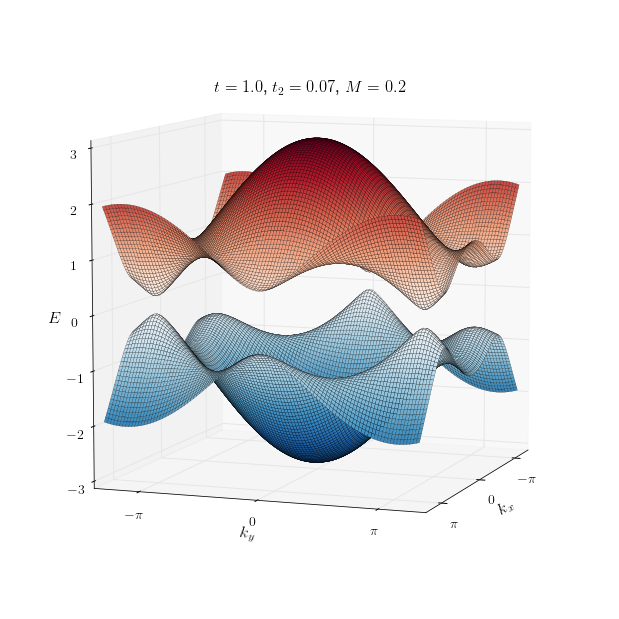
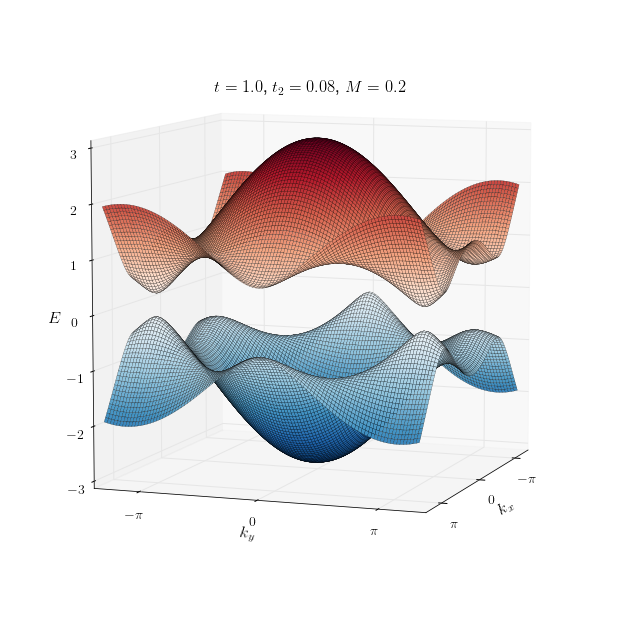
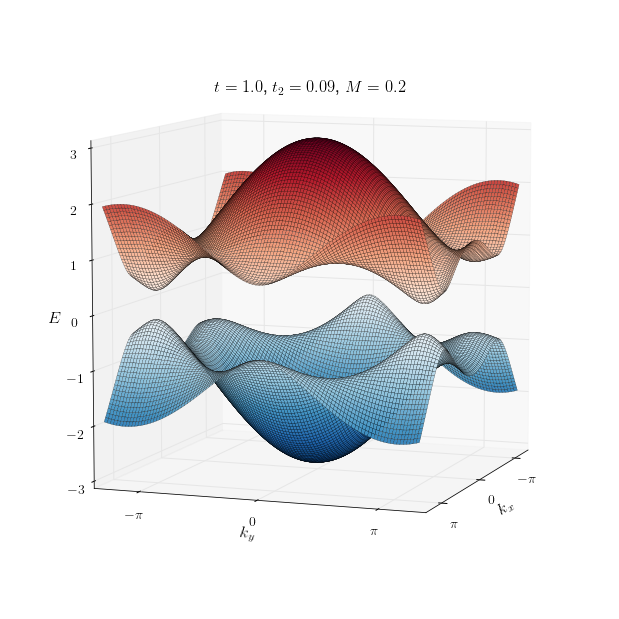
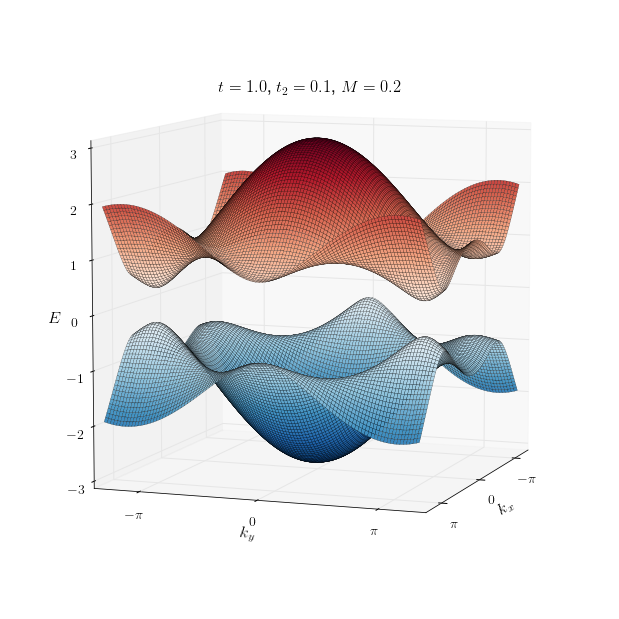

In [4]:
p = SimpleNamespace(t=1.0, m=0.2, phi=np.pi/2, t_2=None)
sys = haldane(boundary='infinite')
k = (4 / 3) * np.linspace(-np.pi, np.pi, 101)
kwargs = {'k_x': k, 'k_y': k, 'title': title}
t_2s = np.linspace(0, 0.10, 11)
holoviews.HoloMap({p.t_2: spectrum(sys, p, **kwargs) for p.t_2 in t_2s}, kdims=[r'$t_2$'])

When $t_2=0$ and at a finite $M$, the system is in a boring gapped phase, generically without zero energy states. As you heard in the video, there might be zero energy states for some specific termination of the lattice, but these are not particularly interesting.

Adding a small $t_2$ initially does not change the situation, but when $t_2$ passes through a value $\pm M/3\sqrt{3}$ the gap closes and changes sign. Importantly, the gap closes *only at one of the two Dirac points*: at $\mathbf{K}'$ for $t_2=M/3\sqrt{3}$ and at $\mathbf{K}$ for $t_2=-M/3\sqrt{3}$.

And when it does, chiral edge states appear! We can see this by looking at the one-dimensional band structure of a ribbon of graphene. To convince you that they are of topological origin, let's look at the bandstructure for ribbons with two different lattice terminations: armchair and zigzag. In a zigzag ribbon, $\mathbf{K}$ and $\mathbf{K}'$ correspond to different momenta parallel to the ribbon direction, while in an armchair one they correspond to the same one.

b':HoloMap   [$t_2$,Boundary]\n   :Path   [$k$,$E/t$]'
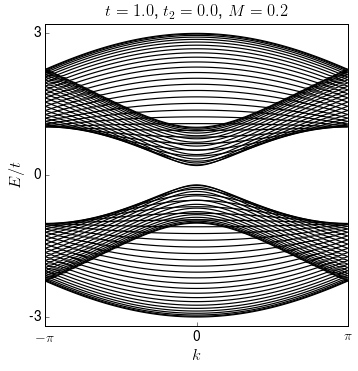
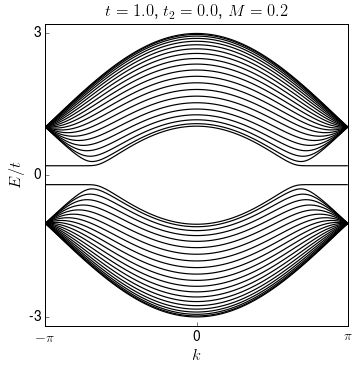
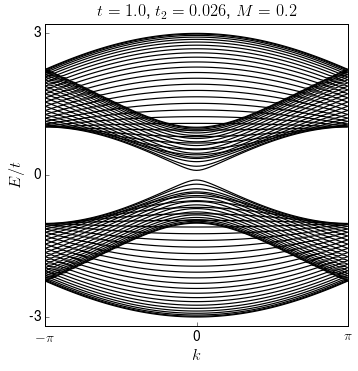
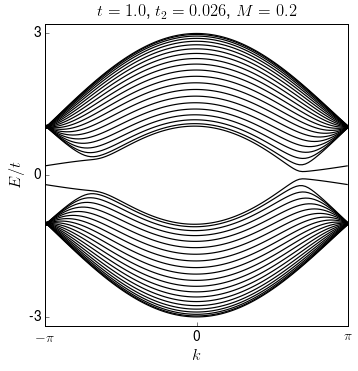
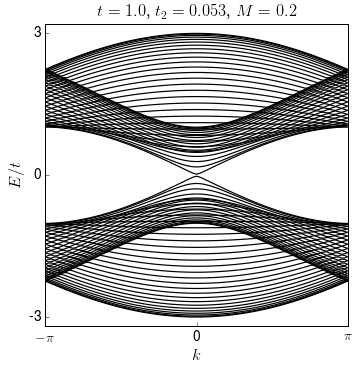
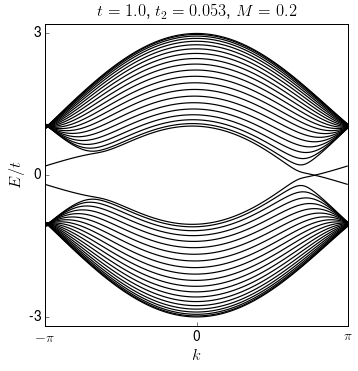
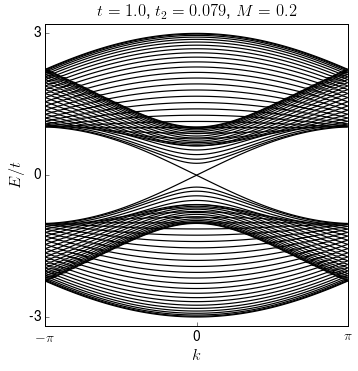
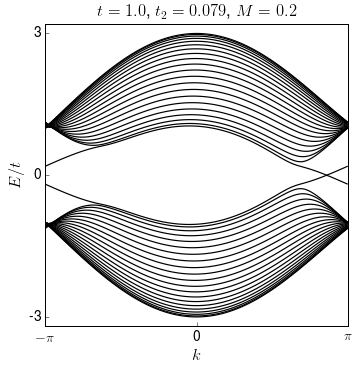
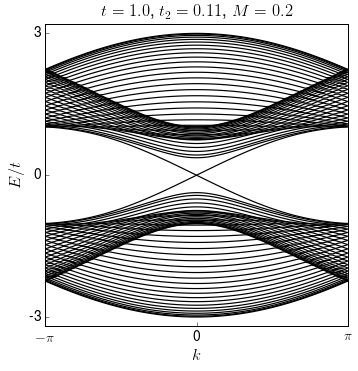
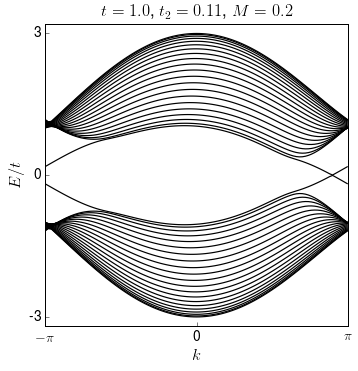
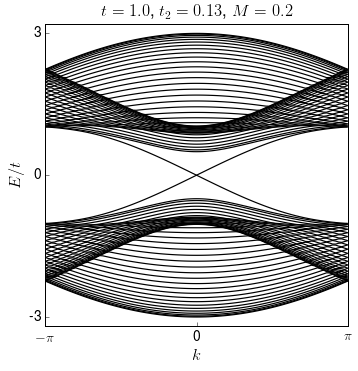
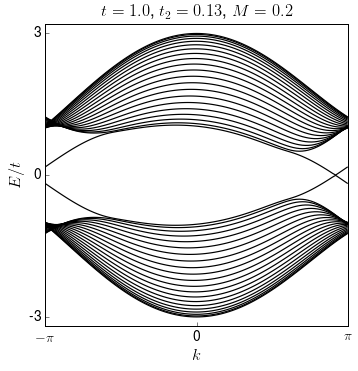
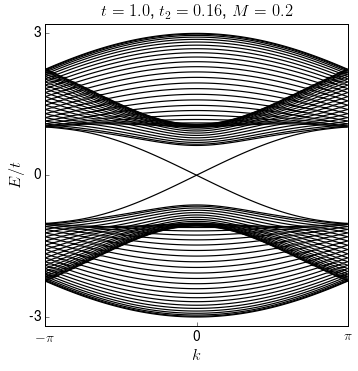
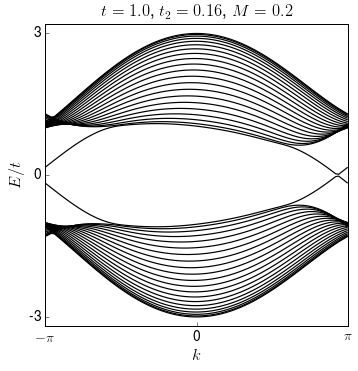
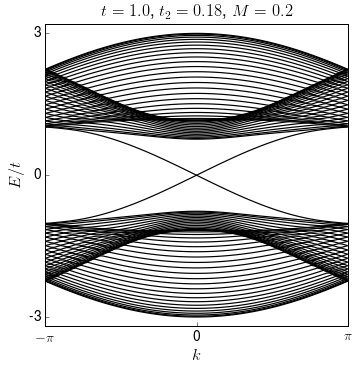
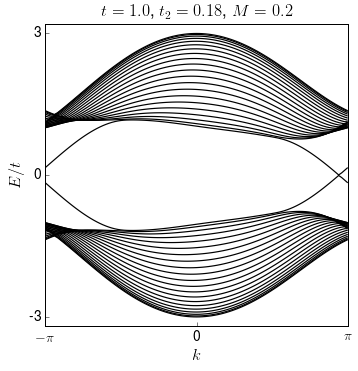
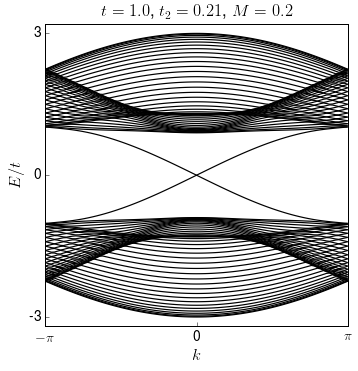
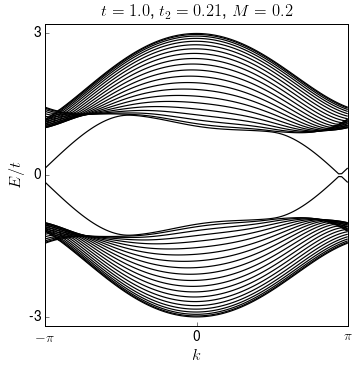
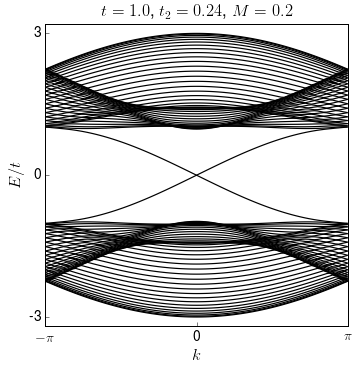
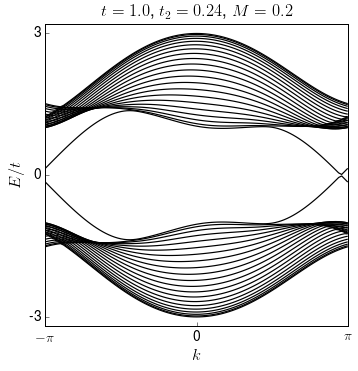
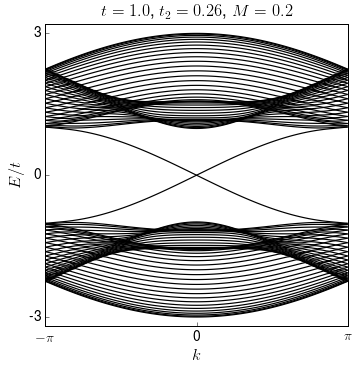
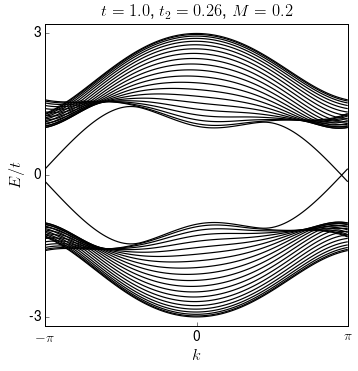
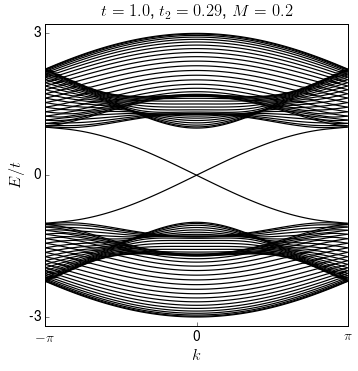
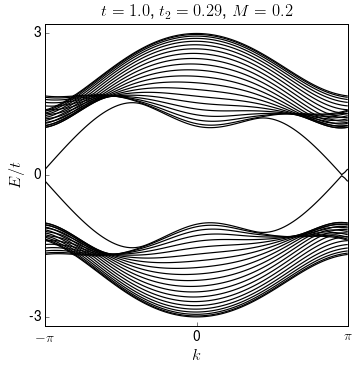
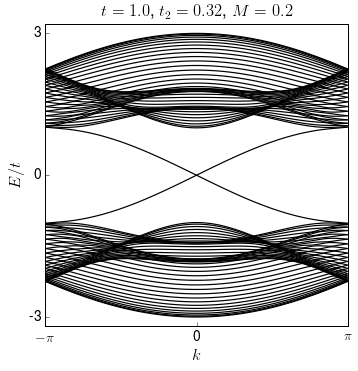
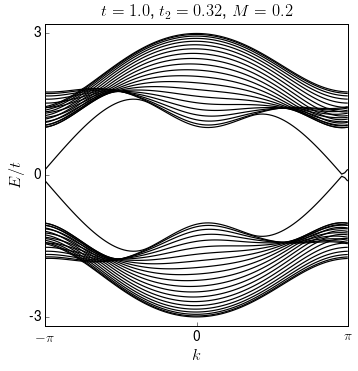
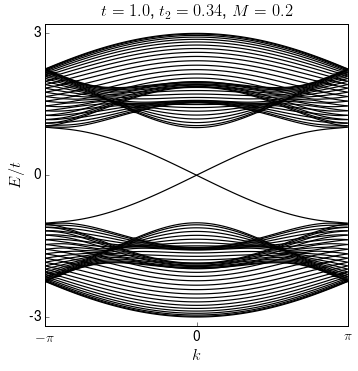
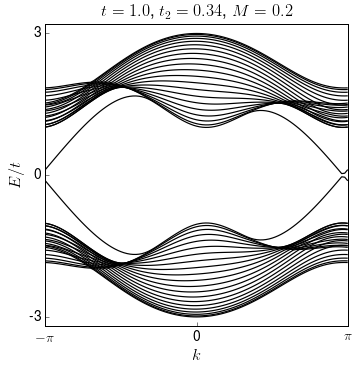
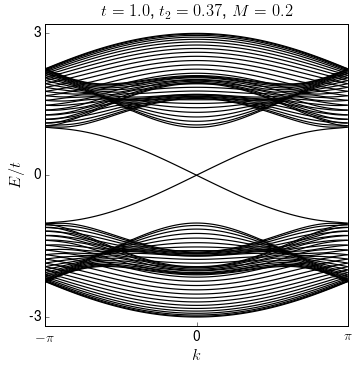
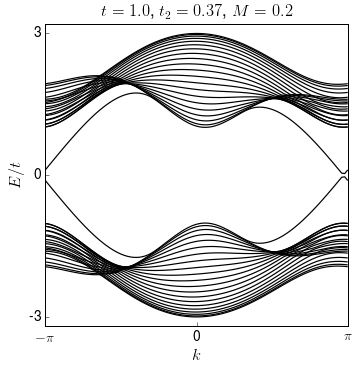
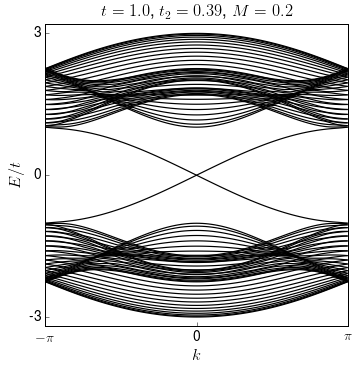
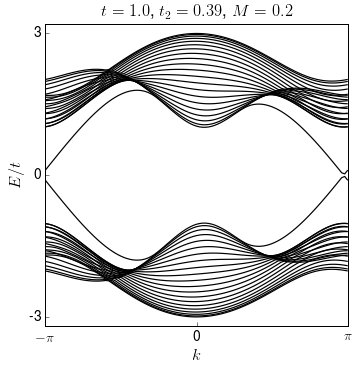
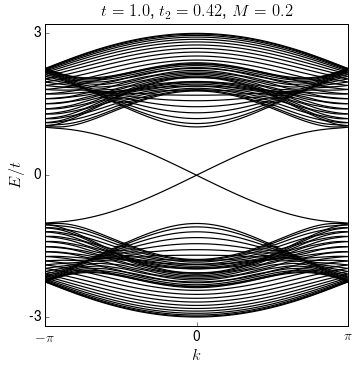
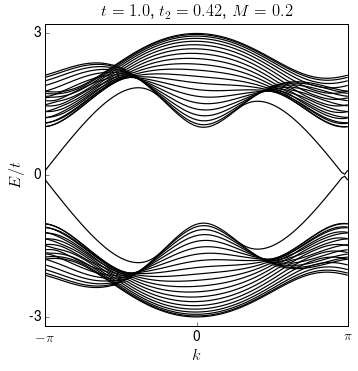
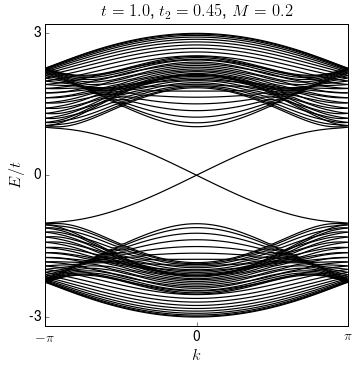
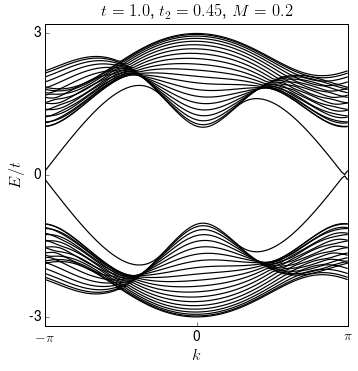
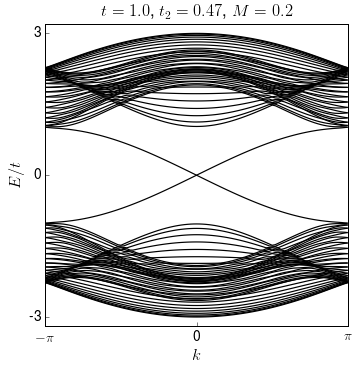
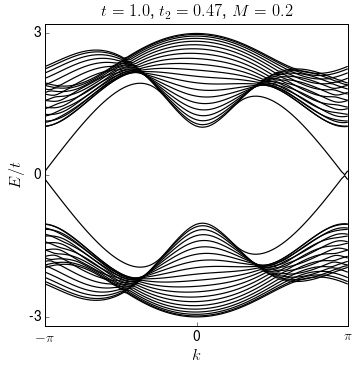
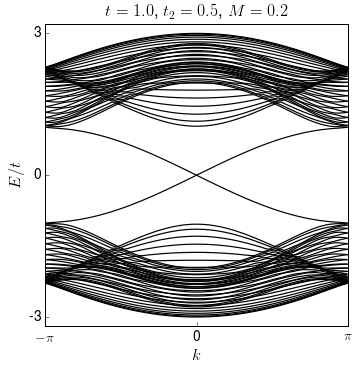
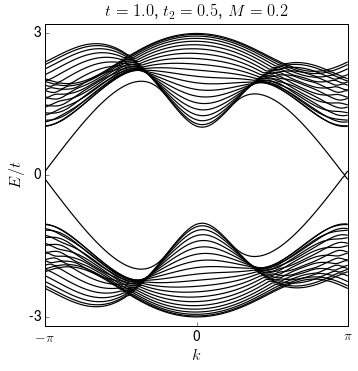

In [5]:
def ribbon_bandstructure(t_2, boundary):
    p = SimpleNamespace(t=1.0, t_2=t_2, m=0.2, phi=np.pi/2)

    if boundary is 'zigzag':
        sys = haldane(w=20, boundary='zigzag')
    elif boundary is 'armchair':
        sys = haldane(w=20, boundary='armchair', )
        
    style = {'k_x': np.linspace(-np.pi, np.pi, 101),
             'xdim': r'$k$',
             'ydim': r'$E/t$',
             'xticks': pi_ticks,
             'yticks': [-3, 0, 3],
             'ylims': [-3.2, 3.2],
             'title': title}
    
    return spectrum(sys, p, **style)

t_2s = np.linspace(0, 0.5, 20)
boundaries = ['zigzag', 'armchair']
plots = {(t_2, boundary): ribbon_bandstructure(t_2, boundary) for t_2 in t_2s for boundary in boundaries}
holoviews.HoloMap(plots, kdims=[r'$t_2$', 'Boundary'])

The appearance of edge states means that graphene has entered a topological phase after the gap closing. This phase is akin to the quantum Hall phase - the edge states are of the same kind. However, as Duncan Haldane explained in the introduction, it is realized without a strong magnetic field.

As you know, this means we have created a **Chern insulator**. The reason for this name will become obvious in the second part of the lecture.

In [6]:
question = ("What happens if we take a Haldane model in the topological phase and turn "
            "on a weak magnetic field?")

answers = ["Magnetic field introduces Landau levels, which change the number of edge states.",
           "Since the magnetic field is weak, nothing changes as long as it doesn't close the gap",
           "The bulk gap closes and there are no edge states anymore.",
           "The gap doesn't close but the edge states may change direction "
           "of propagation, depending on the sign of magnetic field."]

explanation = "Topological robustness is still present, so the number of edge states cannot change unless the gap closes."

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'answers': ['Magnetic field introduces Landau levels, which change the number of edge states.', "Since the magnetic field is weak, nothing changes as long as it doesn't close the gap", 'The bulk gap closes and there are no edge states anymore.', "The gap doesn't close but the edge states may change direction of propagation, depending on the sign of magnetic field."], 'max_attempts': 2, 'correct_answer': 1, 'explanation': 'Topological robustness is still present, so the number of edge states cannot change unless the gap closes.', 'question': 'What happens if we take a Haldane model in the topological phase and turn on a weak magnetic field?'})

# Pumping in terms of Berry phase

Last week we understood the quantum Hall effect in terms of a pumping argument that we attributed to Laughlin.

Our pumping argument involved putting our system on a cylinder and adiabatically pumping a magnetic flux $\Phi$ through the cylinder so that the Hamiltonian returns to itself. The flux enters the Hamiltonian through minimal substitution as $H(\mathbf{k})\rightarrow H(\mathbf{k}+e\mathbf{A})$ where ${\bf A}=\hat{\mathbf{y}}\,\Phi/L$.

Thus we can understand the effects of flux pumping on the Hamiltonian in terms of a change in momentum. When the flux is changed by the appropriate number of quanta, the momentum $\mathbf{k}$ changes by a reciprocal lattice vector and, hence the Bloch Hamiltonian returns to its original value. To simplify the discussion, in the following we will use a square Brillouin zone, with $k_x$ and $k_y$ defined in an interval $[0, 2\pi]$, but all our arguments also apply for the hexagonal Brillouin zone of graphene.

Let's imagine the adiabatic time-evolution of an eigenstate $\left|\psi(\mathbf{k})\right\rangle$ of this Hamiltonian, with energy $E(\mathbf{k})$, as $\mathbf{k}$ is changed slowly. Suppose the Hamiltonian is such that $\left|\psi(\mathbf{k})\right\rangle$ remains non-degenerate as in the case of the Haldane model.  We can then adiabatically explore an energy band by moving $\mathbf{k}$, without the risk of encountering a level crossing. After a while, let's say a time $T$, we bring $\mathbf{k}$ back to its initial value after going around the entire Brillouin Zone. For instance, we can consider the following closed path $C$, where $k_y$ changes by $2\pi$ at a fixed $k_x$, starting from $k_y=0$:

![](figures/bz_path.svg)

We then ask: what is the final quantum state at the time $T$? For a long time people guessed that it would just be given by the initial state $\left|\psi(k_x, k_y+2\pi)\right\rangle\equiv\left|\psi(k_x, k_y)\right\rangle$ times  the usual phase $\exp\left(-i \int_0^T E[\mathbf{k}(t)]\,d t\right)$, which an eigenstate of the Hamiltonian accumulates with time. 

This would be rather boring. Berry instead realized that for a closed loops there is an additional phase $\gamma$, which in our case may depend on $k_x$:

$$\gamma(C) = \oint_C\,\mathbf{A}(\mathbf{k})\,\cdot d\mathbf{k}\,.$$

Here, $\mathbf{A}(\mathbf{k})=i\left\langle\,\psi(\mathbf{k}) \,|\,\nabla_\mathbf{k}\,\psi(\mathbf{k})\right\rangle$ is a vector with two complex entries, which are obtained by taking the derivatives of $\left|\psi(\mathbf{k})\right\rangle$ with respect to $k_x$ and $k_y$ and then taking the inner product with $\left\langle\psi(\mathbf{k})\right|$. This vector goes by the rather obscure name of Berry connection. In our example, the final quantum state at the end of the cycle is thus

$$\exp\,\left[i\gamma(k_x)\right]\,\exp\,\left(-i \int_0^T E[\mathbf{k}(t)]\,d t\right)\,\left|\psi(\mathbf{k})\right\rangle\,.$$

We have made explicit the fact that $\gamma$ in our case may depend on $k_x$. We will not derive the formula for the Berry phase, something which can be done directly from the Schrödinger equation, see for instance [here](http://arxiv.org/abs/0907.2021). What is important to know about $\gamma$ is that it is a **geometric phase**: its value depends on the path $C$ but not on how the path is performed in time, so not on the particular expression for $\mathbf{k}(t)$. We'll soon see that sometimes it can have an even stronger, topological character.  

## Flux pumping

The phase $\gamma(k_x)$ must bear information about the charge pumped during an adiabatic cycle over $k_y$. Now we take advantage of pumped charge being invariant as long as the energy gap is preserved. This means that we have the freedom to change the energy dispersion $E(k_x,k_y)$ arbitrarily, as long as we do not close the gap.

It is convenient to make the energy dispersion completely flat along the $k_x$ direction for $k_y=0$, analogous to the case of Landau levels. In this way, since at fixed $k_y$ all the wave functions have the same energy, we can choose our initial quantum state to be localized in a single unit cell in the $x$ direction,

$$\left|\psi(n,t=0)\right\rangle=\int_0^{2\pi} dk_x\, e^{i k_x n}\,\left|\psi(k_x, k_y=0)\right\rangle\,.$$

Starting from this state, after one adiabatic cycle we obtain

$$\left|\psi(n,t=T)\right\rangle=\int_0^{2\pi} dk_x\, e^{i k_x n}\,\exp\,\left[i\gamma(k_x)-i\theta(k_x)\right]\,\left|\psi(k_x, k_y=2\pi)\right\rangle,$$

where $\theta(k_x)=\int_0^T E[k_x, k_y(t)]\,d t$ is the dynamical phase. Now we notice something strange. While $\theta(k_x)$ is a truly periodic function of $k_x$ because $E(k_x)=E(k_x+2\pi)$, the only restriction on the Berry phase $\gamma(k_x)$ is to be periodic modulo $2\pi$. That is, we can have $\gamma(k_x+2\pi)=\gamma(k_x)+2\pi W$ with $W$ an integer number.

Let's try to deform the dispersion along $k_y$ in order to make the combination $\gamma(k_x)-\theta(k_x)$ as large as possible (just like before, this is allowed as long as we do not close the gap). The best we can do is choose $\theta(k_x)$ so that 

$$\gamma(k_x)-\theta(k_x)=W k_x.$$

Plugging this in to the form of the wave-function we see that 

$$\left|\psi(n,t=T)\right\rangle=\int dk_x e^{i k_x (n+W)}\,\left|\psi(k_x, k_y=0)\right\rangle,$$

which means that every wave function is shifted over by $W$ unit cells. Thus the system with the wave functions $\left|\psi(\mathbf{k})\right\rangle$ pumps $W$ units of charge if the Berry phase satisfies 

$$\gamma(k_x+2\pi)-\gamma(k_x)=2\pi W.$$

> The quantity $W$ is called the **Chern number** and is the topological invariant characterizing the bandstructure of two dimensional quantum Hall systems. Because it is an integer, it cannot be changed by any continuous deformation of the Hamiltonian, provided the gap does not close. The Chern number is in fact the bulk topological invariant for all insulators with broken time-reversal symmetry. If $W=0$, we have a topologically trivial insulator with no chiral edge states. If $W=n$ there are $n$ chiral edge states at the boundary of the insulator.

# Compact form of the Chern number as Berry curvature

We did not denote the Berry connection as $\mathbf{A}(\mathbf{k})$ just by chance. We picked that letter because this vector reminds us a lot of the vector potential $\mathbf{A}(\mathbf{r})$ that is used in electromagnetism.

Just like the vector potential, the definition of $\mathbf{A}(\mathbf{k})$ depends on a particular choice of the person making the calculation. If you decide to multiply the quantum state by a phase, $\left|\psi(\mathbf{k})\right\rangle\,\to \exp\,[i\lambda(\mathbf{k})]\,\left|\psi(\mathbf{k})\right\rangle$, then you get that the Berry connection transforms as $\mathbf{A}(\mathbf{k})\,\to\,\mathbf{A}(\mathbf{k})+\nabla_\mathbf{k} \,\lambda$. However, when you take the integral of $\mathbf{A}(\mathbf{k})$ on a closed path, the result is independent of $\lambda$. That's why the Berry phase is only meaningful for closed paths. 

Now that we have established an analogy with the vector potential, we cannot avoid the idea of taking the curl of the Berry connection, which is known as the **Berry curvature**:

$$\mathbf{\Omega}(\mathbf{k}) = \nabla_\mathbf{k} \times \mathbf{A}(\mathbf{k})=\left[\left\langle \frac{\partial \psi(\mathbf{k})}{\partial k_x}\,\Bigg|\,\frac{\partial\,\psi(\mathbf{k})}{\partial k_y}\right\rangle-\left\langle \frac{\partial \psi(\mathbf{k})}{\partial k_y}\,\Bigg|\,\frac{\partial\,\psi(\mathbf{k})}{\partial k_x}\right\rangle\right]\,.$$

The Berry curvature is like a *magnetic field in momentum space*. Just like the magnetic field $\mathbf{B}(\mathbf{r})=\nabla_\mathbf{r}\times\mathbf{A}(\mathbf{r})$ in electromagnetism, it is a local quantity which does not suffer from the ambiguities of the vector potential (it is gauge independent).

The main advantage of introducing the analogy with the magnetic field is that it motivates us to use Stokes theorem. The Brillouin Zone has the shape of a torus. Therefore the curve $k_x=0$ and $k_x=2\pi$ on the torus bounds the entire Brillouin zone. Using Stokes theorem on this curve we can conclude that 

$$2\pi W=\gamma(2\pi)-\gamma(0)=\iint_{\textrm{BZ}} \mathbf{\Omega}(\mathbf{k})\,\cdot\,d\mathbf{S}\,,$$

where the integral extends over the entire Brillouin Zone.

> As a result of this formalism, we have established two things. First, there is a Chern number which is defined entirely in terms of the momentum space wave functions. Second, the analogy with the magnetic field allows us to obtain an explicit expression for the Chern number in terms of derivatives of the wave functions.

Loosely speaking, a situation with a non-zero Chern number is a bit like having a magnetic monopole, because we have a finite flux coming out of a closed surface. Now, you probably know that experimentally a magnetic monopole was never observed. For our Chern number in the Brillouin zone the situation is more exciting, as situations where it is non-zero are realized in nature.

To see how this can happen, we first have to understand the following: if there is Berry curvature in the Brillouin zone, what are its sources?

# Gap closings are sources of Berry curvature

The Berry phase can only be computed if the Hamiltonian has a gap. For a Hamiltonian $H(\mathbf{k})$ with many bands $E_n(\mathbf{k})$, this means that we can compute the Chern number only for an isolated band $E_n(\mathbf{k})$ which does not touch any other band. If there is a band touching, the Berry phase is undefined.

Now let's go back to our analogy with electromagnetism. We know that we cannot compute the electric or magnetic flux through a surface if there are electric or magnetic charges sitting exactly on it. That's because the electric or magnetic fields are *not defined* at the points where their sources are.

This analogy suggests the following: that the sources for Berry flux in momentum space are points where two bands touch, just like the Dirac points at the $\mathbf{K}$ and $\mathbf{K}'$ points of the Brillouin zone in graphene.

This may sound a bit abstract and confusing: where are these points located? We are used to thinking about sources of flux in real space, not in momentum space. In fact, just like you do with a two-dimensional sphere surrounding a charge in three-dimensional space, you can think of the Brillouin zone as lying in a three-dimensional space, with two directions given by $k_x$ and $k_y$ and the third given by the **magnitude of the energy gap**. 

The situation is explained by the following sketch, which also gives a bird's-eye view of the phase diagram of the Haldane model as a function of the ratio $t_2/M$:

![](figures/phasediagram.svg)

What you see in the sketch above is a schematic illustration of the energy spectrum close to the Dirac points in the Brillouin zone, for some representative values of $t_2/M$ (for simplicity we drew the Brillouin zone as a square and not a hexagon, but that's not essential). The two massless Dirac cones appearing for $t_2=\pm M/(3\sqrt{3})$ are the sources of the Berry curvature, which then “spreads“ along the vertical axis, passing through the Brillouin zones of the gapped phases.

The $t_2=0$ Brillouin zone is “sandwiched“ between the two gap closings: it has opposite curvature for the two Dirac points, and a total Chern number of zero.

The Brillouin zones for $|t_2|>M/(3\sqrt{3})$, on the other hand, have Berry curvature with the same sign for both Dirac points, and a total Chern number equal to $\pm 1$.

To see this more clearly, we can compute the Berry curvature numerically and plot it over the whole Brillouin zone as a function of $t_2$:

b':HoloMap   [$t_2$]\n   :Image   [$k_x$,$k_y$]   (z)'
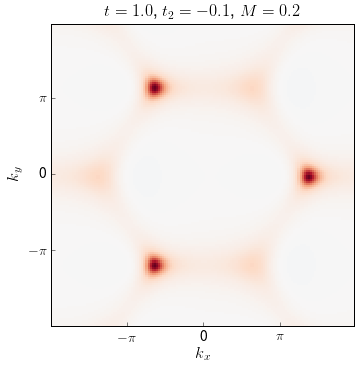
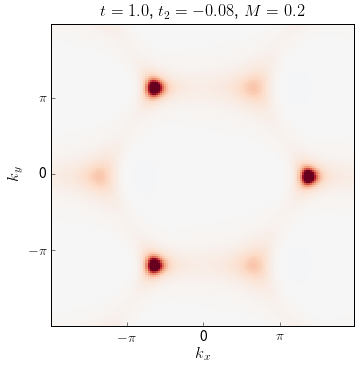
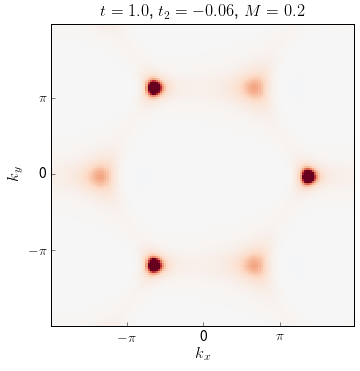
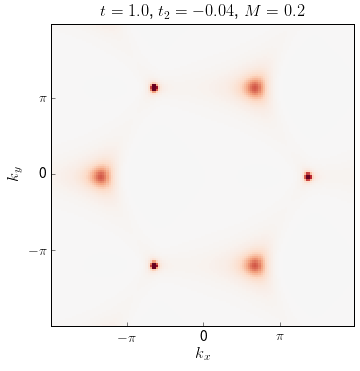
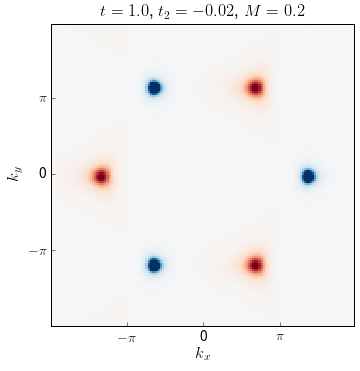
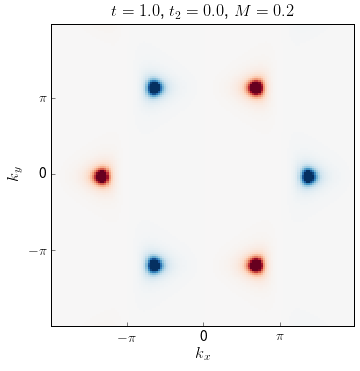
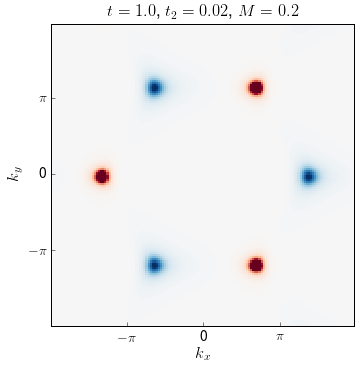
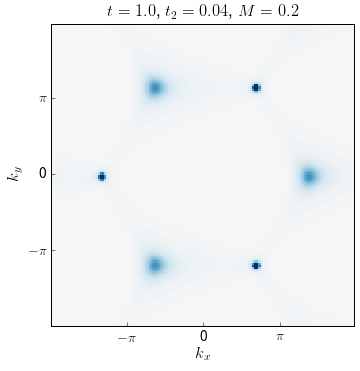
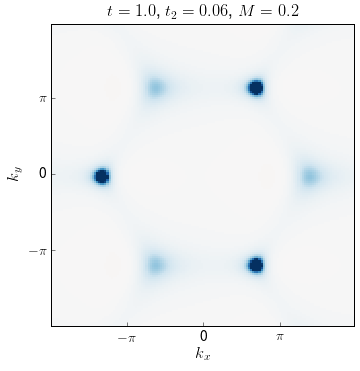
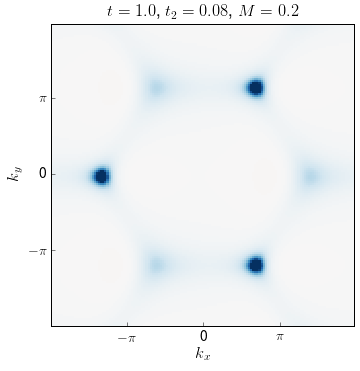
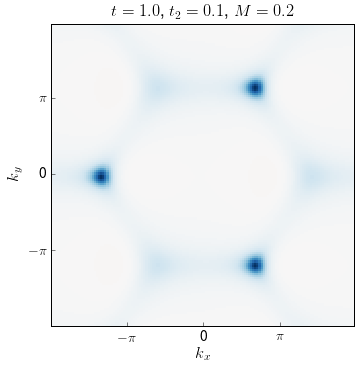

In [7]:
p = SimpleNamespace(t=1.0, m=0.2, phi=np.pi/2, t_2=None)
sys = haldane(boundary='infinite')
kwargs = {'title': title, 'ks': np.linspace(-2*np.pi, 2*np.pi, 150, endpoint=False)}
t_2s = np.linspace(-0.1, 0.1, 11)
holoviews.HoloMap({p.t_2: plot_berry_curvature(sys, p, **kwargs) for p.t_2 in t_2s}, kdims=[r'$t_2$'])

In [8]:
question = "How does time-reversal symmetry influence the Berry curvature?"

answers = ["The Berry curvature breaks time-reversal, so it must be zero if time-reversal is present.",
           "Time reversal symmetry doesn't constrain Berry curvature at all.",
           "There is no constraint, only the integral of Berry curvature (Chern number) should be zero.",
           "The Berry curvature and momentum change sign under time-reversal, so that the Berry curvature "
           "at one momentum becomes opposite to the Berry curvature at opposite momentum."]

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3)

MoocMultipleChoiceAssessment(**{'correct_answer': 3, 'display_name': 'Question', 'answers': ['The Berry curvature breaks time-reversal, so it must be zero if time-reversal is present.', "Time reversal symmetry doesn't constrain Berry curvature at all.", 'There is no constraint, only the integral of Berry curvature (Chern number) should be zero.', 'The Berry curvature and momentum change sign under time-reversal, so that the Berry curvature at one momentum becomes opposite to the Berry curvature at opposite momentum.'], 'question': 'How does time-reversal symmetry influence the Berry curvature?', 'max_attempts': 2})

You can see that the Berry curvature is really located around the Dirac points. Around $t_2=0$, the two Dirac points give canceling contributions. After a gap closing however, the contribution of one of the two Dirac points changes sign, so that the two add to $\pm 1$ instead of canceling each other.

From both the plots above, you can also infer that each Dirac point always contributes a Berry curvature equal to $\pm 1/2$, depending on the sign of the mass in the effective Dirac Hamiltonian. We always obtain an integer number because the number of Dirac points in the Brillouin zone is even. It also implies that when the gap changes sign at a Dirac point, the Chern number changes by exactly one!

At the same time it's important to know that the particular distribution of the Berry curvature depends on all the details of the eigenstates of the Hamiltonian, so it changes a lot from model to model. And in fact, it is a special feature of the Haldane model that the Berry curvature is focused around two distinct points in the Brillouin zone.

For instance, here is a slider plot for the Berry curvature for the quantum Hall lattice model studied in the previous chapter.

b':HoloMap   [$\\mu$]\n   :Image   [$k_x$,$k_y$]   (z)'
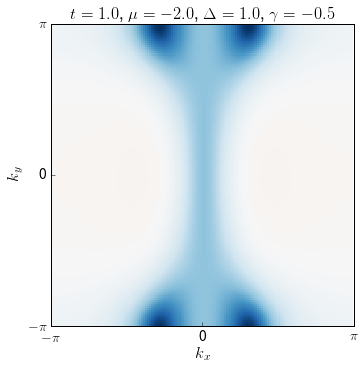
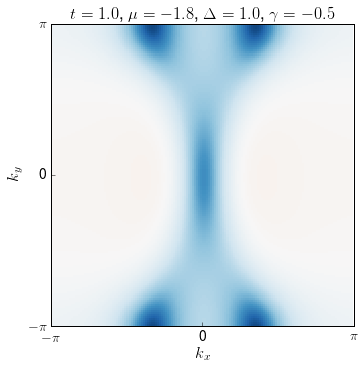
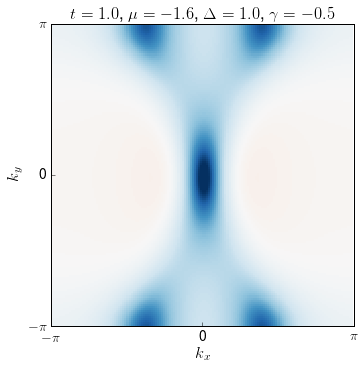
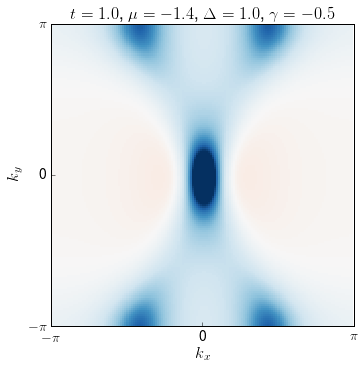
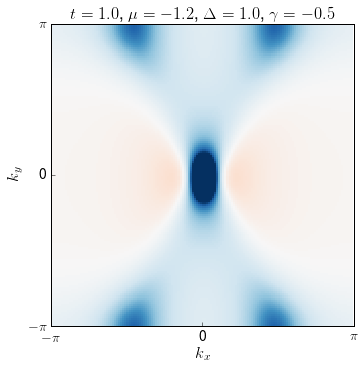
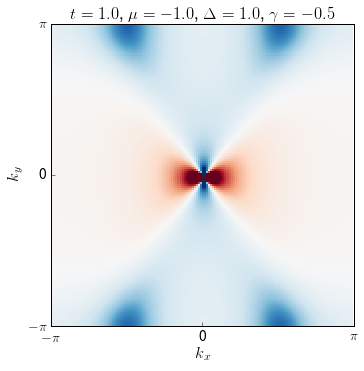
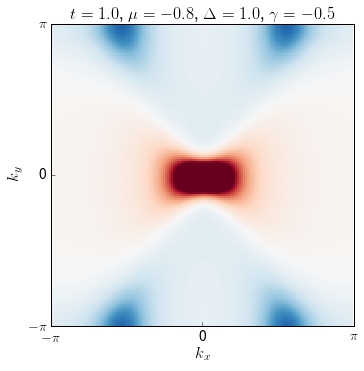
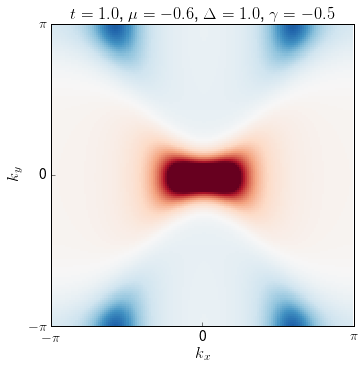
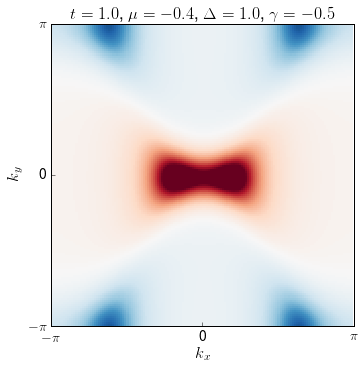
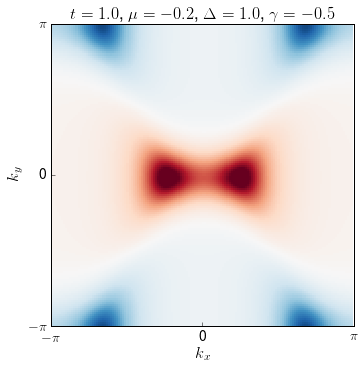
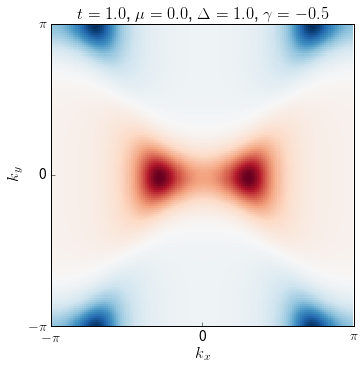

In [9]:
p = SimpleNamespace(t=1.0, delta=1.0, gamma=-0.5, mu=None)
sys = Qi_Wu_Zhang()

def title_Qi(p):
    title = r'$t={:.2}$, $\mu={:.2}$, $\Delta={:.2}$, $\gamma={:.2}$'
    return title.format(p.t, p.mu, p.delta, p.gamma)

kwargs = {'title': title_Qi}
mus = np.linspace(-2, 0, 11)
holoviews.HoloMap({p.mu: plot_berry_curvature(sys, p, **kwargs) for p.mu in mus}, kdims=[r'$\mu$'])

You can see that for $\mu < -2t - 2\gamma$ there is a net curvature, and that when $\mu = -2t - 2\gamma$ some flux of opposite sign appears at $k_x = k_y=0$, the Dirac point, which leaves no net curvature and leads to a change in the Chern number. This is the signature of the topological transition seen from the Berry curvature.

# Summary: extending the model to spinful electrons and photons

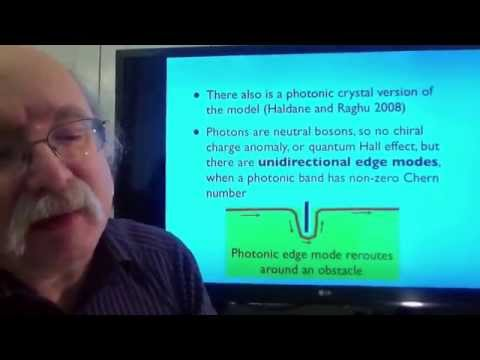

In [10]:
MoocVideo("0gxE68kvdmw", src_location='4.2-summary')

**Questions about what you just learned? Ask them below!**

In [11]:
MoocDiscussion("Questions", "Haldane model")

MoocDiscussion(**{'discussion_target': 'Haldane model', 'display_name': 'Haldane model', 'discussion_category': 'Questions', 'discussion_id': 'f59afbb6609369b2794250f9452140d8'})